In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action = 'ignore')
%matplotlib inline
from sklearn import preprocessing
import math

In [51]:
def devide_sample(x_train,y_train,spoches):
        index_spoches = np.zeros(len(x_train)-len(x_train)%spoches)
        index_list = list(range(0,len(x_train)))
        for i in range(len(x_train)-len(x_train)%spoches):
            index = np.random.choice(index_list)
            index_spoches[i] = index
            index_list.remove(index)
        index_spoches = index_spoches.reshape(spoches,int((len(x_train)-(len(x_train)%spoches))/spoches)).astype(int)
        return index_spoches

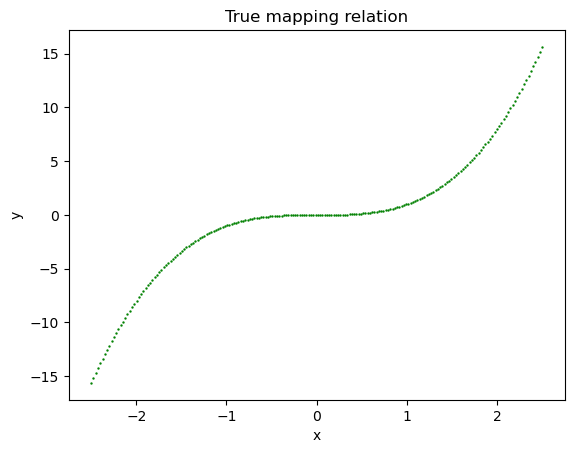

In [52]:
n = 200#sample size
x = np.linspace(2.5,-2.5,n)
y = x**3
plt.figure()
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x,y,color="green",s=0.5)
plt.title("True mapping relation")
plt.show()

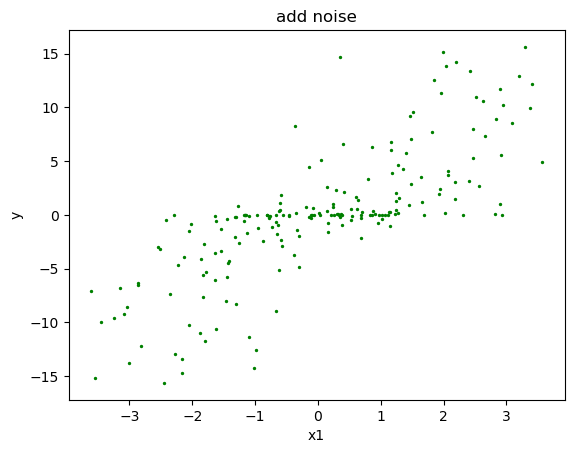

In [53]:
x1 = x+np.random.normal(0,1,n)
plt.figure()
plt.xlabel("x1")
plt.ylabel("y")
plt.scatter(x1,y,color="green",s=2)
plt.title("add noise")
plt.show()

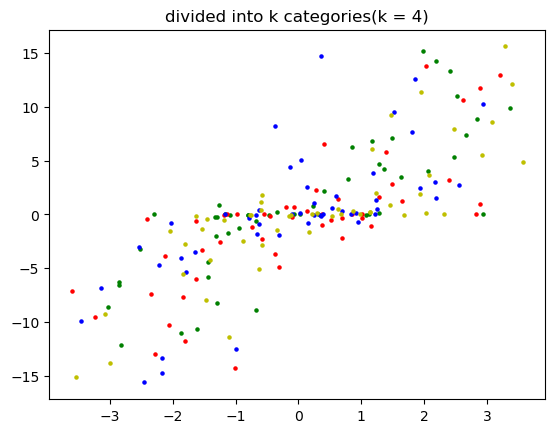

In [54]:
spoches = 4 # hyperparameters K
index = devide_sample(x1,y,spoches)
plt.figure()
a = ["green","red","b","y"]
for i in range(4):
    index1 = np.argsort(x1[index[i]])
    plt.scatter(x1[index[i][index1]],y[index[i][index1]],color=a[i],s=5)
    plt.title("divided into k categories(k = 4)")
plt.show()

In [55]:
#AMLI method
eta = 100#one of the hyperparameters in AMLI method
x_point=[]
y_point=[]
for k in range(spoches):
    x_set = x1[index[k]]
    y_set = y[index[k]]
    sort_index = np.argsort(x_set)
    for i in range(len(x_set)):
        if i == len(x_set)-1:
            continue
        cha = eta*(x_set[sort_index[i+1]]-x_set[sort_index[i]])
        x_point.append(np.linspace(x_set[sort_index[i]],x_set[sort_index[i+1]],int(cha)))
        y_point.append(np.linspace(y_set[sort_index[i]],y_set[sort_index[i+1]],int(cha)))
for i in x_point:
    x1 = np.hstack((x1,i))
for i in y_point:
    y = np.hstack((y,i))
a,i = 0,0
for i in range(x1.shape[0]):
    a += round((round(y[i]**(1/3),3)-x1[i])**2,3)
    i += 1
    if i ==98:
        break
print(f"after AMLI method, the number of simple: {x1.shape[0]}")

after AMLI method, the number of simple: 2780


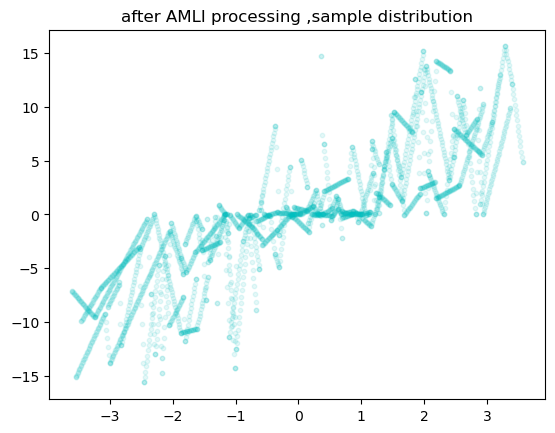

In [56]:
plt.figure()
plt.scatter(x1,y,color="c",s=10,alpha=0.1)
plt.title("after AMLI processing ,sample distribution")
plt.show()

In [57]:
#AMLI method
class AMLI_method:
    
    def __init__(self,spoches=4,distance=2,number_parameter=2):
        self.spoches = spoches
        self.distance = distance
        self.number_parameter = number_parameter
        
    def _distance(self,x1,x2):
        if x1.ndim >1 or x2.ndim>1:
            return np.linalg.norm(x1-x2,ord = self.distance,axis=1)
        else:
            return np.linalg.norm(x1-x2,ord = self.distance)
        
    def devide_sample(self,x_train,y_train):#dividing k sets
        index_spoches = np.zeros(len(x_train)-len(x_train)%self.spoches)
        index_list = list(range(0,len(x_train)))
        for i in range(len(x_train)-len(x_train)%self.spoches):
            index = np.random.choice(index_list)
            index_spoches[i] = index
            index_list.remove(index)
        self.index_spoches = index_spoches.reshape(self.spoches,
                                                   int((len(x_train)-(len(x_train)%self.spoches))/self.spoches)).astype(int)
        self.x_train = x_train
        self.y_train = y_train
        
    def k_interpolate(self):#K-linear interpolation filling
        x_point = []
        y_point = []
        for k in range(self.spoches):
            xk_set = self.x_train[self.index_spoches[k]]
            yk_set = self.y_train[self.index_spoches[k]]
            distance = np.linalg.norm(xk_set,ord=self.distance,axis=1)
            xk_set = xk_set[np.argsort(distance)]
            yk_set = yk_set[np.argsort(distance)]
            remaining_xset = xk_set
            remaining_yset = yk_set
            for i in range(len(xk_set)):
                if i == len(xk_set)-1:
                    continue
                elif i == 0:
                    point_x = xk_set[i]
                    point_y = yk_set[i]
                    remaining_xset = remaining_xset[1:]
                    remaining_yset = remaining_yset[1:]
                distance = self._distance(point_x,remaining_xset)
                min_index = np.argmin(distance)
                x_point.append((np.linspace(point_x,remaining_xset[min_index],int(self.number_parameter*distance[min_index]))))
                y_point.append((np.linspace(point_y,remaining_yset[min_index],int(self.number_parameter*distance[min_index]))))
                point_x = remaining_xset[min_index]
                point_y = remaining_yset[min_index]
                remaining_xset = np.delete(remaining_xset,min_index,axis=0)
                remaining_yset = np.delete(remaining_yset,min_index,axis=0)
        for i in x_point:
            self.x_train = np.vstack((self.x_train,i))
        for i in y_point:
            self.y_train = np.hstack((self.y_train,i))
        
        return self.x_train,self.y_train

In [58]:
n = 1000#sample size
k = 25#hyperparameters K
eta = 5#hyperparameters eta
train_data = pd.read_csv("shared bicycle set.csv")
X = train_data.iloc[:n,1:11].values
y = train_data.iloc[:n,11].values
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
model = AMLI_method(spoches=k,number_parameter=eta)
model.devide_sample(x_train,y_train)
a1,b1=model.k_interpolate()
print(f"Initial sample size: {n} , after AMLI method sample size: {a1.shape[0]}")

Initial sample size: 1000 , after AMLI method sample size: 185660


In [59]:
#knn
from sklearn import neighbors
for k in range(1,120,5):
    modelKNN=neighbors.KNeighborsRegressor(n_neighbors=k,weights='distance')
    modelKNN.fit(x_train,y_train)
    y_pred = modelKNN.predict(x_test)
    print("before AMLI , k:",(k),",  MSE:",(mean_squared_error(y_pred,y_test)))
for k in range(1,120,5):
    modelKNN=neighbors.KNeighborsRegressor(n_neighbors=k,weights='distance')
    modelKNN.fit(a1,b1)
    y_pred = modelKNN.predict(x_test)
    print("after AMLI , k:",(k),",  MSE:",(mean_squared_error(y_pred,y_test)))

before AMLI , k: 1 ,  MSE: 237.56333333333333
before AMLI , k: 6 ,  MSE: 208.22749856299717
before AMLI , k: 11 ,  MSE: 266.9846846567706
before AMLI , k: 16 ,  MSE: 313.2873370408232
before AMLI , k: 21 ,  MSE: 370.81075044470543
before AMLI , k: 26 ,  MSE: 433.95148309273645
before AMLI , k: 31 ,  MSE: 512.1316247026934
before AMLI , k: 36 ,  MSE: 581.3835550214714
before AMLI , k: 41 ,  MSE: 660.0635044657482
before AMLI , k: 46 ,  MSE: 740.0692123130682
before AMLI , k: 51 ,  MSE: 819.5541018355701
before AMLI , k: 56 ,  MSE: 889.964688710384
before AMLI , k: 61 ,  MSE: 970.6653863337285
before AMLI , k: 66 ,  MSE: 1015.6994406767656
before AMLI , k: 71 ,  MSE: 1097.3587755643173
before AMLI , k: 76 ,  MSE: 1180.2264304981336
before AMLI , k: 81 ,  MSE: 1254.6101246999397
before AMLI , k: 86 ,  MSE: 1321.3586054435987
before AMLI , k: 91 ,  MSE: 1411.7803294102262
before AMLI , k: 96 ,  MSE: 1493.89400432195
before AMLI , k: 101 ,  MSE: 1572.2352971720836
before AMLI , k: 106 ,  MS

In [60]:
#fnn
from sklearn.neural_network import MLPRegressor
model =MLPRegressor()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
mes1 = mean_squared_error(y_pred,y_test)
model =MLPRegressor()
model.fit(a1,b1)
y_pred = model.predict(x_test)
mes2 = mean_squared_error(y_pred,y_test)
print("before AMLI MSE:%f\nafter AMLI MSE:%f"%(mes1,mes2))

before AMLI MSE:1.212354
after AMLI MSE:0.010727


In [46]:
#GBDT
from sklearn.ensemble import GradientBoostingRegressor
for i in range(10,300,20):
    model2 = GradientBoostingRegressor(n_estimators=i)
    model2.fit(x_train,y_train)
    y_pred = model2.predict(x_test)
    print("before AMLI, loss:%f , n_estimators:%d"%(mean_squared_error(y_test,y_pred),i))
for i in range(10,300,20):
    model2 = GradientBoostingRegressor(n_estimators=i)
    model2.fit(a1,b1)
    y_pred = model2.predict(x_test)
    print("after AMLI, loss:%f , n_estimators:%d"%(mean_squared_error(y_test,y_pred),i))

before AMLI, loss:5150.547654 , n_estimators:10
before AMLI, loss:382.901592 , n_estimators:30
before AMLI, loss:170.636395 , n_estimators:50
before AMLI, loss:138.247937 , n_estimators:70
before AMLI, loss:128.078764 , n_estimators:90
before AMLI, loss:120.451952 , n_estimators:110
before AMLI, loss:115.984167 , n_estimators:130
before AMLI, loss:109.839565 , n_estimators:150
before AMLI, loss:106.094578 , n_estimators:170
before AMLI, loss:100.683889 , n_estimators:190
before AMLI, loss:98.778783 , n_estimators:210
before AMLI, loss:101.404889 , n_estimators:230
before AMLI, loss:99.778155 , n_estimators:250
before AMLI, loss:99.972656 , n_estimators:270
before AMLI, loss:95.818400 , n_estimators:290
after AMLI, loss:6734.877262 , n_estimators:10
after AMLI, loss:349.477657 , n_estimators:30
after AMLI, loss:117.041416 , n_estimators:50
after AMLI, loss:88.154413 , n_estimators:70
after AMLI, loss:79.346641 , n_estimators:90
after AMLI, loss:74.359144 , n_estimators:110
after AMLI, l

In [47]:
#RF
from sklearn.ensemble import RandomForestRegressor
for i in range(1,201,20):
    regressor = RandomForestRegressor(n_estimators=i, random_state=0)
    regressor.fit(x_train,y_train)
    y_pred = regressor.predict(x_test)
    print("before AMLI, loss:%f , n_estimators:%d"%(mean_squared_error(y_test,y_pred),i))
for i in range(1,201,20):
    regressor = RandomForestRegressor(n_estimators=i, random_state=0)
    regressor.fit(a1, b1)
    y_pred = regressor.predict(x_test)
    print("after AMLI, loss:%f , n_estimators:%d"%(mean_squared_error(y_test,y_pred),i))

before AMLI, loss:577.560000 , n_estimators:1
before AMLI, loss:245.733394 , n_estimators:21
before AMLI, loss:246.989334 , n_estimators:41
before AMLI, loss:234.646222 , n_estimators:61
before AMLI, loss:234.500696 , n_estimators:81
before AMLI, loss:230.812125 , n_estimators:101
before AMLI, loss:236.395425 , n_estimators:121
before AMLI, loss:232.022028 , n_estimators:141
before AMLI, loss:227.624279 , n_estimators:161
before AMLI, loss:228.055207 , n_estimators:181
after AMLI, loss:226.034604 , n_estimators:1
after AMLI, loss:185.912412 , n_estimators:21
after AMLI, loss:186.204197 , n_estimators:41
after AMLI, loss:184.443563 , n_estimators:61
after AMLI, loss:184.475372 , n_estimators:81
after AMLI, loss:184.264667 , n_estimators:101
after AMLI, loss:184.258757 , n_estimators:121
after AMLI, loss:183.564109 , n_estimators:141
after AMLI, loss:183.556987 , n_estimators:161
after AMLI, loss:184.158951 , n_estimators:181
